In [23]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 학습 모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc


import warnings
from sklearn.exceptions import FitFailedWarning

import joblib

# FitFailedWarning을 무시하기 위한 코드
warnings.filterwarnings('ignore', category=FitFailedWarning)



# 데이터 불러오기
data = pd.read_csv('parkhaemin_20to24.csv')
data.head()

,Date,Team,Inning,Pitcher,Batter,BC,Result,Prev,Next,LEV,REs,REa,WPe,WPa
0,04월 26일,KIA,6회말,곽도규,2 박해민,2 (0-1),우익수 방면 1루타,"2사 1,2루 6:5",2사 2루 6:7,2.98,0.488,1.899,72.90%,0.348
1,05월 26일,NC,5회말,카스타노,2 박해민,1 (0-0),중견수 방면 3루타,1사 만루 3:2,1사 3루 3:5,3.81,1.775,2.250,85.00%,0.291
2,04월 02일,NC,4회말,하트,1 박해민,1 (0-0),좌익수 방면 1루타,"2사 2,3루 2:0",2사 1루 2:2,2.56,0.608,1.618,52.80%,0.207
3,03월 23일,한화,4회말,류현진,1 박해민,1 (0-0),중견수 방면 1루타,"2사 1,3루 2:2","2사 1,3루 2:3",2.18,0.541,1.000,68.80%,0.128
4,04월 26일,KIA,5회말,네일,2 박해민,4 (1-2),우익수 방면 1루타,1사 만루 5:1,"1사 1,2루 5:3",2.87,1.741,1.247,34.10%,0.124


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2813 entries, 0 to 2812
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2813 non-null   object 
 1   Team     2813 non-null   object 
 2   Inning   2813 non-null   object 
 3   Pitcher  2813 non-null   object 
 4   Batter   2813 non-null   object 
 5   BC       2606 non-null   object 
 6   Result   2813 non-null   object 
 7   Prev     2813 non-null   object 
 8   Next     2813 non-null   object 
 9   LEV      2813 non-null   float64
 10  REs      2813 non-null   float64
 11  REa      2813 non-null   float64
 12  WPe      2813 non-null   object 
 13  WPa      2813 non-null   float64
dtypes: float64(4), object(10)
memory usage: 307.8+ KB


In [25]:
################## 전처리 ######################


#  아웃 카운트
def determine_outcount(x):
    if '무사' in x:
        return 0
    elif '1사' in x:
        return 1
    elif '2사' in x:
        return 2
    else:
        return None  # 만약 '무사', '1사', '2사'가 아닌 다른 값이 있다면 None을 할당

data['out_count'] = data['Prev'].apply(lambda x: determine_outcount(x))

# 'BC' 컬럼에 NaN 값이 있는 경우, 타격 외의 상황이므로 제외 (도루, 견제 등)
data = data.dropna(subset=['BC'])

# WPe에서 %를 떼고 숫자형으로 변환
data['WPe'] = data['WPe'].str.rstrip('%').astype(float)

# 볼 카운트
data[['ball', 'strike']] = data['BC'].str.extract(r'\((\d+)-(\d+)\)')



# 주자 위치
def extract_runners(prev_str):
    runner_positions = {'base_1': 0, 'base_2': 0, 'base_3': 0}
    if '1루' in prev_str:
        runner_positions['base_1'] = 1
    if '2루' in prev_str:
        runner_positions['base_2'] = 1
    if '3루' in prev_str:
        runner_positions['base_3'] = 1

    # 복수 주자 상황 처리 (예: '1,2루')
    matches = re.findall(r'(\d)루', prev_str)
    for match in matches:
        runner_positions[f'base_{match}'] = 1
    
    return pd.Series(runner_positions)


# 'Prev' 컬럼을 사용하여 주자 위치를 표시하는 컬럼을 추가합니다.
data[['base_1', 'base_2', 'base_3']] = data['Prev'].apply(extract_runners)

data['base_1'] = data['base_1'].astype('object')
data['base_2'] = data['base_2'].astype('object')
data['base_3'] = data['base_3'].astype('object')

# 'Result' 컬럼을 사용하여 타자의 결과 (0: 아웃 혹은 삼진, 1: 그 외)
data['result'] = data['Result'].apply(lambda x: 0 if '삼진' in x or '아웃' in x else 1)

# 안쓰는 데이터 아웃
data = data.drop(['Date', 'Team', 'Inning', 'Batter','Pitcher', 'BC', 'Result', 'Prev', 'Next', 'REa', 'WPa', 'Batter'], axis=1)

#object -> int dtype 변경
ob_col = ['ball', 'strike', 'base_1', 'base_2', 'base_3']

for col in ob_col:
    data[col] = data[col].astype(int)

# 데이터 확인
data.head(1000)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2811
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LEV        2606 non-null   float64
 1   REs        2606 non-null   float64
 2   WPe        2606 non-null   float64
 3   out_count  2606 non-null   int64  
 4   ball       2606 non-null   int64  
 5   strike     2606 non-null   int64  
 6   base_1     2606 non-null   int64  
 7   base_2     2606 non-null   int64  
 8   base_3     2606 non-null   int64  
 9   result     2606 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 224.0 KB


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모든 피처의 레이블별 타겟값 분포 시각화 함수 (서브플롯 사용)
def plot_label_distribution_by_feature(df, target_col, cols):
    num_features = len(cols)
    num_cols = 3  # 한 행에 3개의 서브플롯을 배치
    num_rows = (num_features + num_cols - 1) // num_cols  # 행의 수 계산

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # 2D 배열을 1D 배열로 변환

    for i, col in enumerate(cols):
        sns.countplot(x=col, hue=df[target_col].astype(str), data=df, ax=axes[i])
        axes[i].set_title(f'Distribution of {target_col} by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].legend(title=target_col)

    # 빈 서브플롯 숨기기
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [27]:
def calculate_label_ratios(df, target_col, cols):
    ratio_list = []

    for col in cols:
        ratios = df.groupby(col)[target_col].value_counts(normalize=True).unstack().fillna(0)
        if 0 in ratios and 1 in ratios:
            ratios['ratio_0_to_1'] = ratios[0] / ratios[1]
            ratio_list.append(ratios[['ratio_0_to_1']].rename(columns={'ratio_0_to_1': f'{col}_ratio_0_to_1'}))
        else:
            print(f"Column {col} does not have both 0 and 1 values for {target_col}")

    return pd.concat(ratio_list, axis=1)

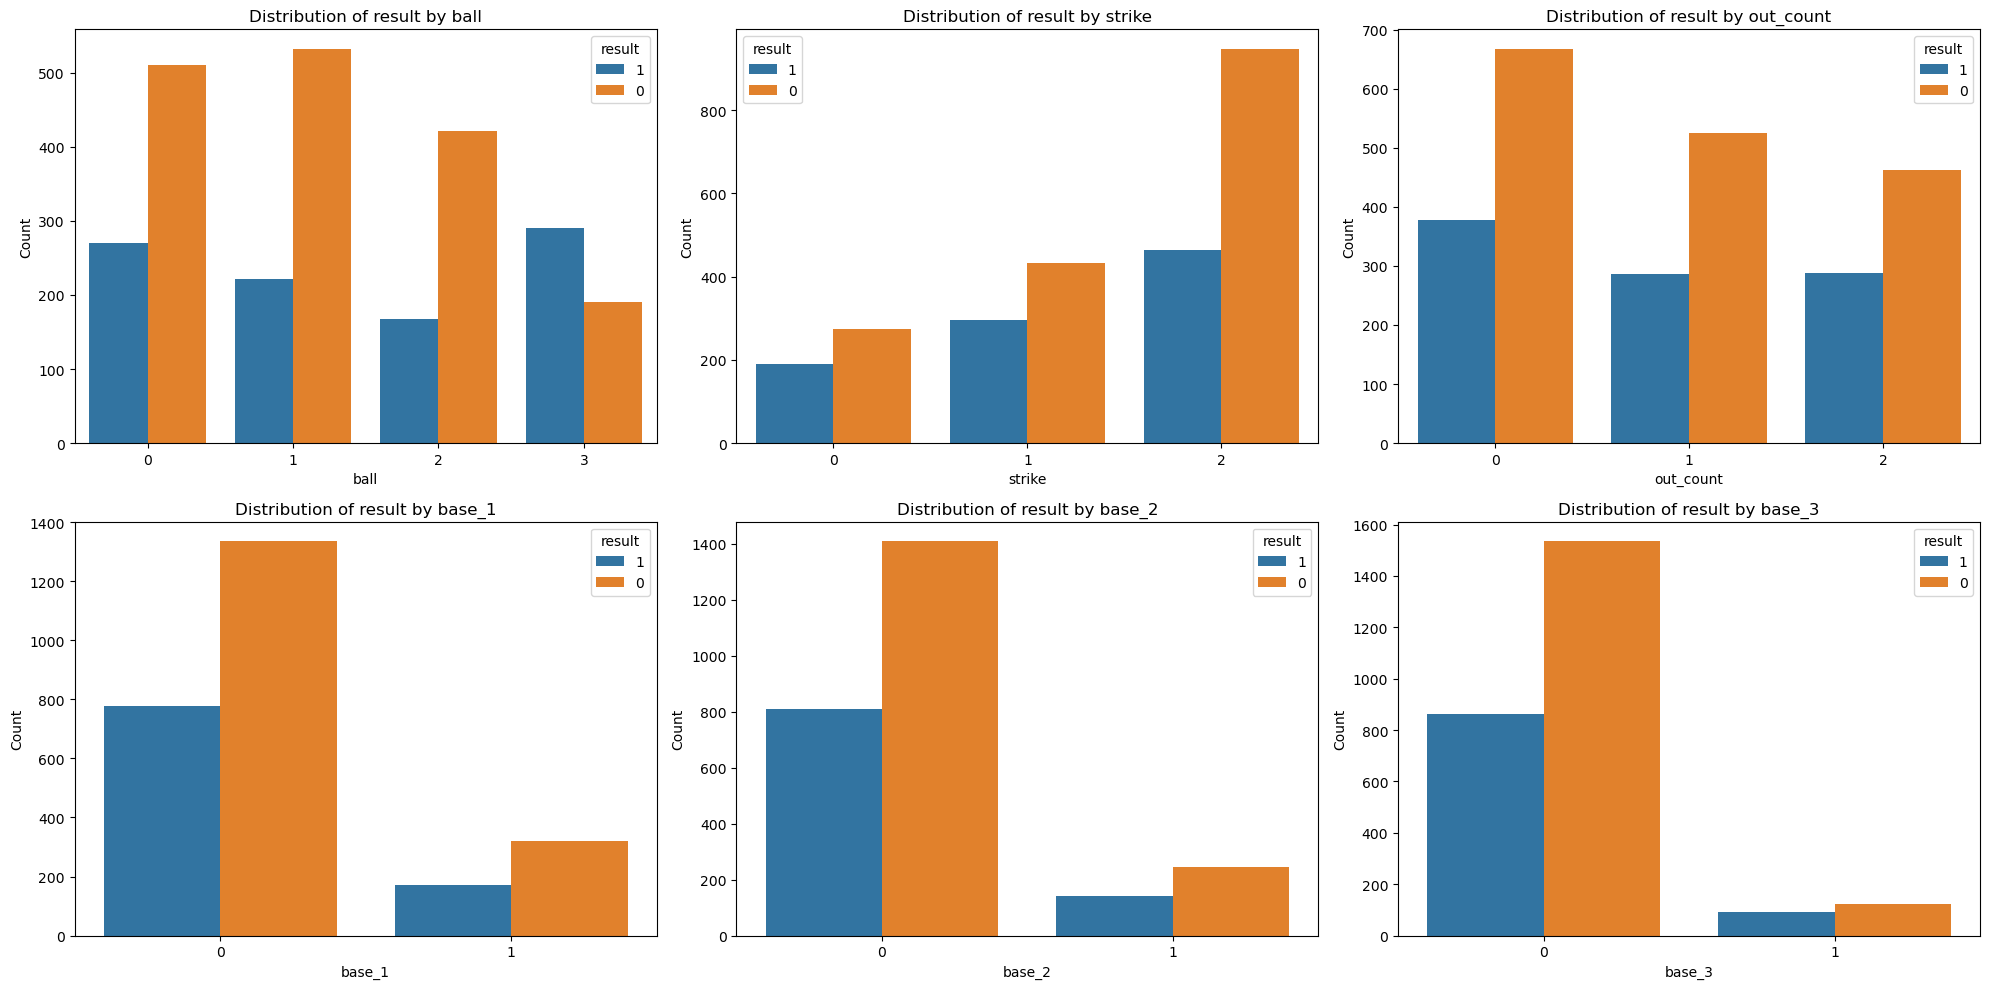

In [28]:
cols = ['ball', 'strike', 'out_count', 'base_1', 'base_2', 'base_3']

plot_label_distribution_by_feature(data, 'result', cols)

In [29]:
calculate_label_ratios(data, 'result', cols)

result,ball_ratio_0_to_1,strike_ratio_0_to_1,out_count_ratio_0_to_1,base_1_ratio_0_to_1,base_2_ratio_0_to_1,base_3_ratio_0_to_1
0,1.892593,1.434555,1.769231,1.715938,1.737361,1.781649
1,2.396396,1.461279,1.835664,1.849711,1.757143,1.344444
2,2.505952,2.045356,1.607639,NaN,NaN,NaN
3,0.656357,NaN,NaN,NaN,NaN,NaN


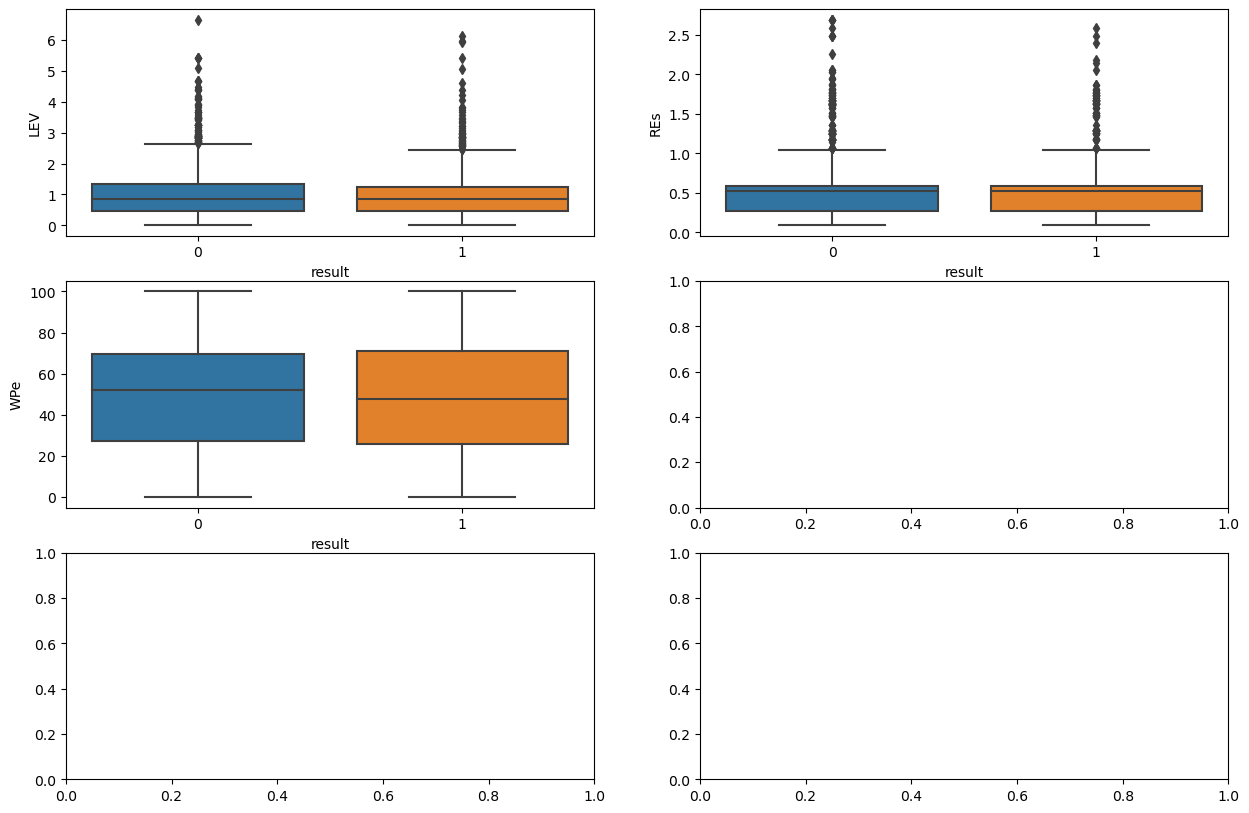

In [30]:
continuous_vars = ['LEV','REs','WPe']

# 플롯의 행과 열을 설정
n_rows = 3
n_cols = 2

# matplotlib의 subplots를 사용하여 여러 그래프를 그립니다.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# 각 변수에 대한 Boxplot을 그립니다.
for i, var in enumerate(continuous_vars):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(x='result', y=var, data=data, ax=axes[row, col])

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 피처별 히스토그램 시각화 함수 (서브플롯 사용)
def plot_features_histograms(df, features, bins=30):
    num_features = len(features)
    num_cols = 3  # 한 행에 3개의 서브플롯을 배치
    num_rows = (num_features + num_cols - 1) // num_cols  # 행의 수 계산

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # 2D 배열을 1D 배열로 변환

    for i, feature in enumerate(features):
        sns.histplot(df[feature], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')

    # 빈 서브플롯 숨기기
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [32]:
data.info()
data.head(300)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2811
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LEV        2606 non-null   float64
 1   REs        2606 non-null   float64
 2   WPe        2606 non-null   float64
 3   out_count  2606 non-null   int64  
 4   ball       2606 non-null   int64  
 5   strike     2606 non-null   int64  
 6   base_1     2606 non-null   int64  
 7   base_2     2606 non-null   int64  
 8   base_3     2606 non-null   int64  
 9   result     2606 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 224.0 KB


,LEV,REs,WPe,out_count,ball,strike,base_1,base_2,base_3,result
0,2.98,0.488,72.9,2,0,1,0,1,0,1
1,3.81,1.775,85.0,1,0,0,0,0,0,1
2,2.56,0.608,52.8,2,0,0,0,0,1,1
3,2.18,0.541,68.8,2,0,0,0,0,1,1
4,2.87,1.741,34.1,1,1,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
324,1.80,0.530,75.3,1,3,2,1,0,0,1
325,1.80,0.530,75.3,1,0,2,1,0,0,1
326,1.45,0.523,60.3,0,1,2,0,0,0,1
327,1.80,0.266,50.0,1,1,2,0,0,0,1


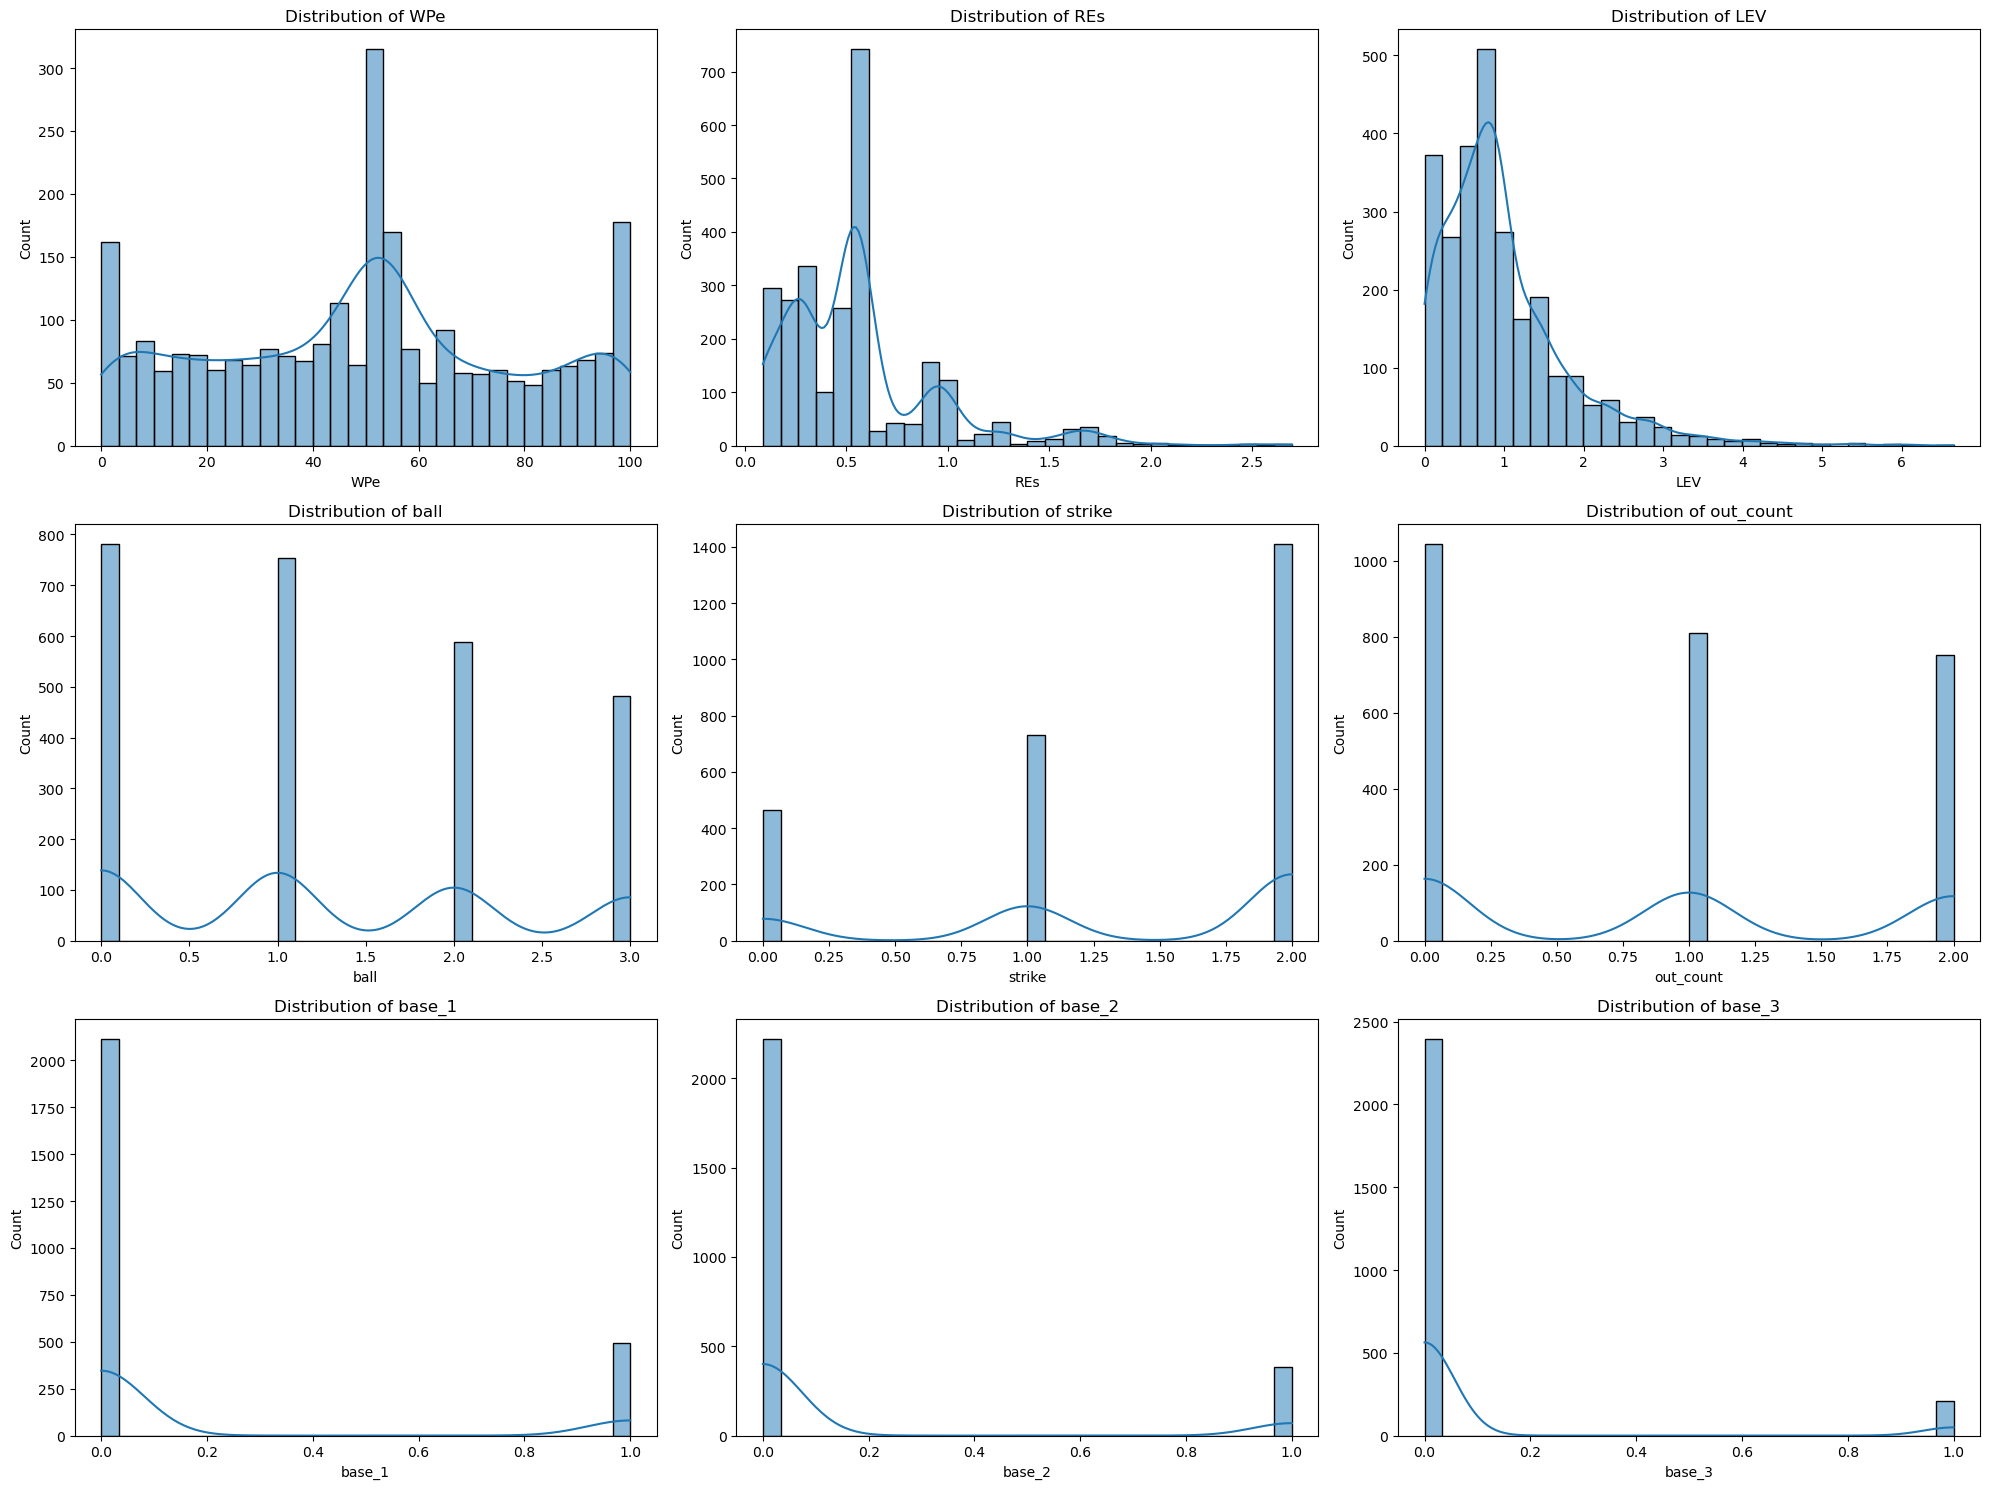

In [33]:
# 숫자형 칼럼과 카테고리형 칼럼 분리
numeric_features = ['WPe', 'REs', 'LEV', 'ball', 'strike', 'out_count']
categorical_features = ['base_1', 'base_2', 'base_3']
features = numeric_features + categorical_features

# 숫자형 데이터 스케일링 전 피처 분포 확인
plot_features_histograms(data, features)

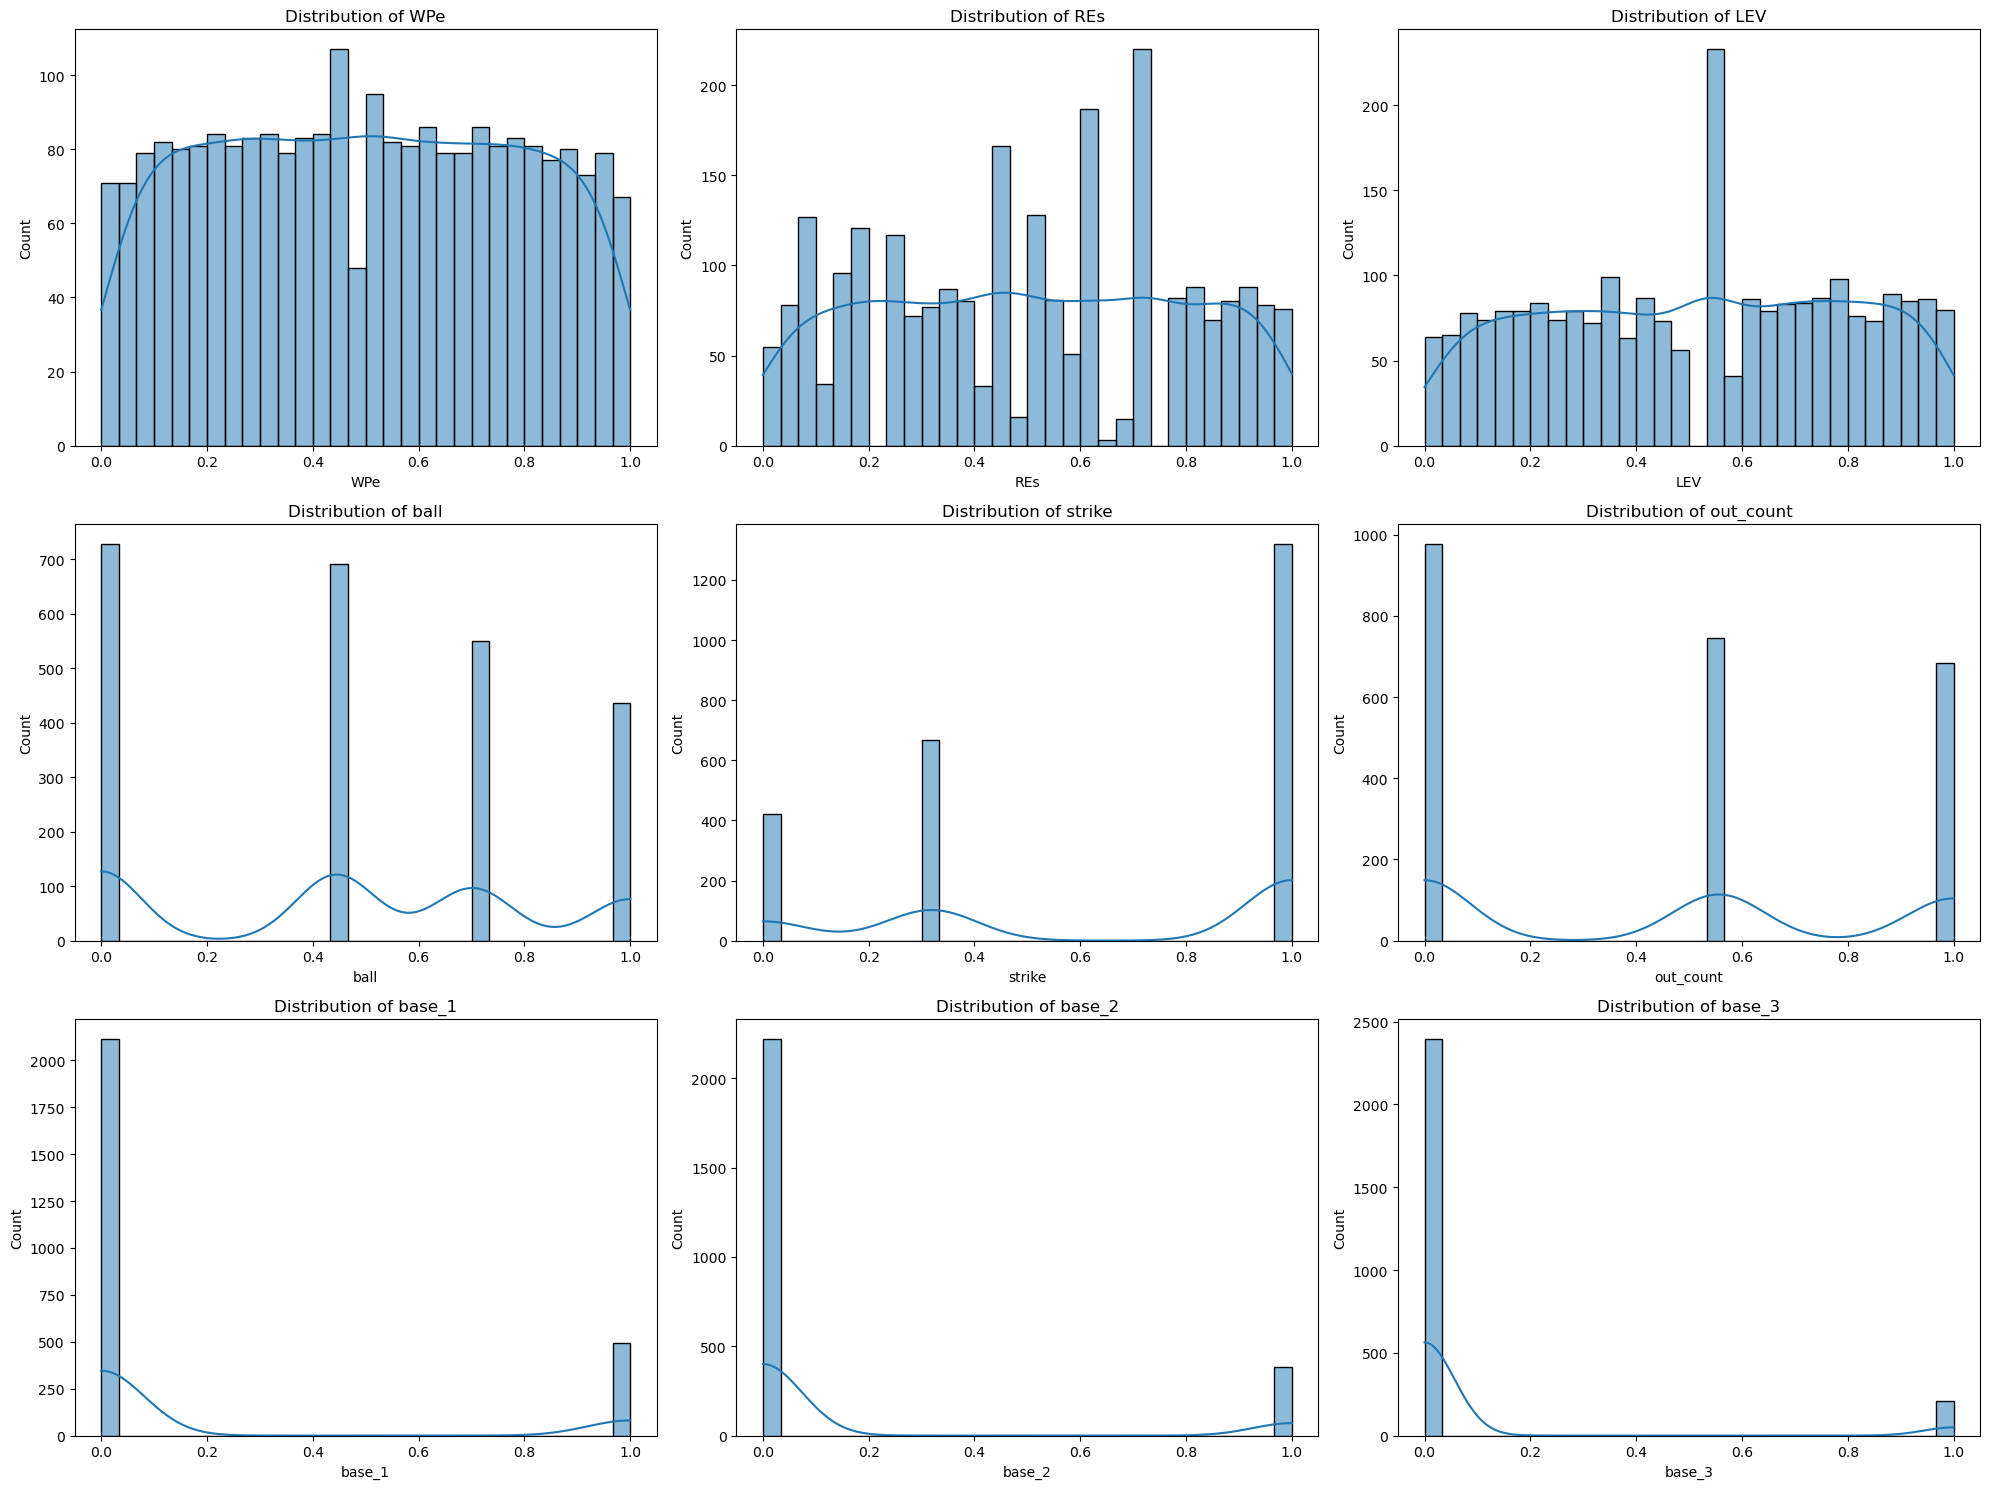

In [34]:
# 숫자형 데이터 스케일링
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()

# 정규화된 데이터로 변환
numeric_data = data[numeric_features]
numeric_data_scaled = scaler.fit_transform(numeric_data)
numeric_data_scaled_df = pd.DataFrame(numeric_data_scaled, columns=numeric_features)

joblib.dump(scaler, 'scaler.pkl')

# 스케일링된 숫자형 데이터를 원래 데이터셋에 대체
for feature in numeric_features:
    data[feature] = numeric_data_scaled_df[feature]

# 숫자형 데이터 스케일링 후 피처 분포 확인
plot_features_histograms(data, features)

In [35]:
# 원-핫 인코딩
one_hot_encoded_columns = pd.get_dummies(data[categorical_features], drop_first=True)
data = data.drop(categorical_features, axis=1)
data = pd.concat([data, one_hot_encoded_columns], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2811
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LEV        2406 non-null   float64
 1   REs        2406 non-null   float64
 2   WPe        2406 non-null   float64
 3   out_count  2406 non-null   float64
 4   ball       2406 non-null   float64
 5   strike     2406 non-null   float64
 6   result     2606 non-null   int64  
 7   base_1     2606 non-null   int64  
 8   base_2     2606 non-null   int64  
 9   base_3     2606 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 224.0 KB


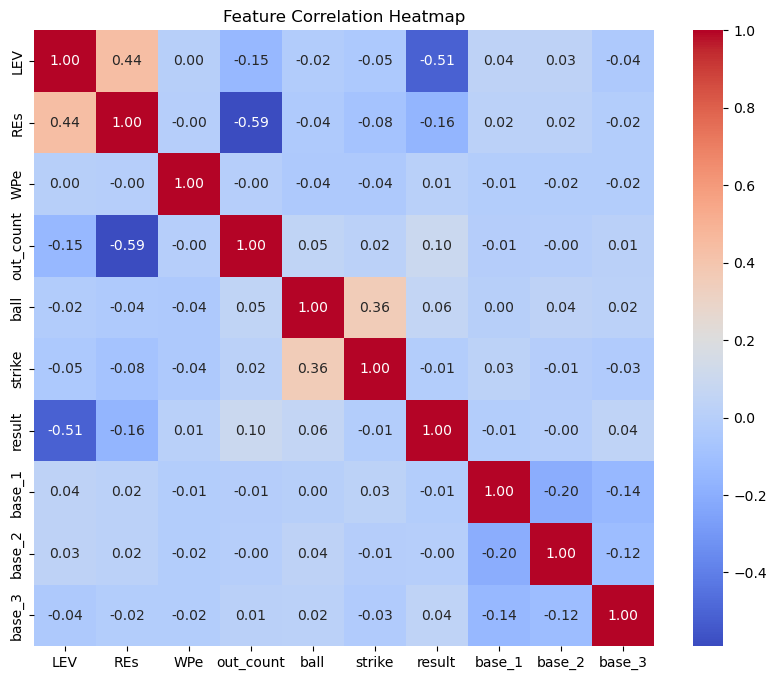

In [36]:
############ 피처별 상관관계 ##############


# 피처 간 상관계수 계산
corr = data.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [37]:
## roc-auc 시각화 ##

def plot_roc_curve(y_true, y_scores):
    # ROC 곡선 계산
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # ROC-AUC 그래프 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

In [38]:
############### 분류 모델 #################


# 학습 모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier


# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

############## 학습 ################


# 데이터 분할
X = data.drop('result', axis=1)  # 'target'은 예측하고자 하는 목표 변수
y = data['result']


### 테스트 사이즈 바꿀때마다 성능 달라짐 !! ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
# 트리 기반 분류 모델
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42), 
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42))
}

# 하이퍼파라미터 그리드 설정
param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 5, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 20, 30],
        'min_samples_leaf': [1, 2, 4, 5, 10, 20],
        'max_features': [None, 'auto', 'sqrt', 'log2'],
        'class_weight': [None, 'balanced']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],   # 트리 개수
        'max_depth': [None, 10, 20, 30],   # 트리의 최대 깊이
        'min_samples_split': [2, 5, 10],   # 노드를 분할하기 위한 최소 샘플 수
        'min_samples_leaf': [1, 2, 4],     # 리프 노드에 있어야 할 최소 샘플 수
        'bootstrap': [True, False],         # 부트스트랩 샘플링 사용 여부
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],      # 트리 개수
        'learning_rate': [0.01, 0.1, 0.2],  # 학습률
        'max_depth': [3, 4, 5],              # 트리의 최대 깊이
        'min_samples_split': [2, 5, 10],     # 노드를 분할하기 위한 최소 샘플 수
        'min_samples_leaf': [1, 2, 4],       # 리프 노드에 있어야 할 최소 샘플 수
        'subsample': [0.8, 0.9, 1.0],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [-1, 3, 4, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],  # 트리의 개수
        'learning_rate': [0.01, 0.1, 1.0],  # 학습률
        'base_estimator__max_depth': [1, 2, 3],  # 기본 약한 학습기 (의사결정나무)의 최대 깊이
        'base_estimator__min_samples_split': [2, 5, 10],  # 노드를 분할하기 위한 최소 샘플 수
        'base_estimator__min_samples_leaf': [1, 2, 4]  # 리프 노드에 있어야 할 최소 샘플 수
    }
}

In [40]:
def fit_model(model, param_grid, X_train, y_train):
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),
        model
    )
    
    param_grid = {f"{pipeline.steps[-1][0]}__{key}": value for key, value in param_grid.items()}
    
    # 그리드 서치 설정
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    # 모델 학습 및 하이퍼파라미터 튜닝
    grid_search.fit(X_train, y_train)
    # 최적의 모델로 예측
    best_model = grid_search.best_estimator_
    return best_model

In [41]:
def scale_features(input_features_0, input_features_1):
    # 저장된 스케일러를 로드
    scaler = joblib.load('scaler.pkl')
    # 입력 피처값을 2차원 배열로 변환 (scikit-learn의 입력 형식에 맞춤)
    input_features_array_0= np.array(input_features_0).reshape(1, -1)
    input_features_array_1= np.array(input_features_1).reshape(1, -1)
    # 피처값을 스케일링
    scaled_features_0 = scaler.transform(input_features_array_0)
    scaled_features_1 = scaler.transform(input_features_array_1)
    return scaled_features_0, scaled_features_1

In [42]:
def search_in_model(model_path, input_features):
    model = joblib.load(model_path)
    i = 1
    for features in input_features:
        baseball_situation = np.array(features).reshape(1, -1)
        result = model.predict(baseball_situation)
        if result == 0:
            final_result = "출루"
        else:
            final_result = "아웃"
        print(str(i) + "번째 상황의 출루 예측 결과 : \n" + final_result)

        i += 1

baseball_Decision Tree.pkl
=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       416
           1       0.71      0.65      0.68       236

    accuracy                           0.78       652
   macro avg       0.76      0.75      0.75       652
weighted avg       0.77      0.78      0.77       652

ROC AUC: 0.8176




/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.75536888 0.73234573 0.75741622 ... 0.73797626 0.71903731 0.73797626]
  warnings.warn(
/var/folders/7g/d7k_fhd53k5118b5rr2p83c00000gn/T/ipykernel_36050/2178713767.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


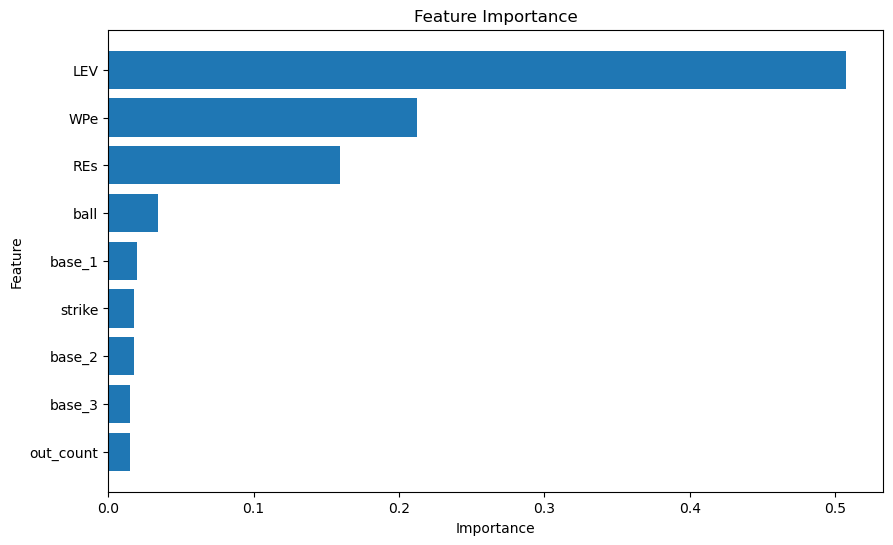

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


1번째 상황의 출루 예측 결과 : 
출루
2번째 상황의 출루 예측 결과 : 
출루
baseball_Random Forest.pkl
=== Random Forest ===
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       416
           1       0.75      0.70      0.73       236

    accuracy                           0.81       652
   macro avg       0.79      0.79      0.79       652
weighted avg       0.81      0.81      0.81       652

ROC AUC: 0.8871




/var/folders/7g/d7k_fhd53k5118b5rr2p83c00000gn/T/ipykernel_36050/2178713767.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


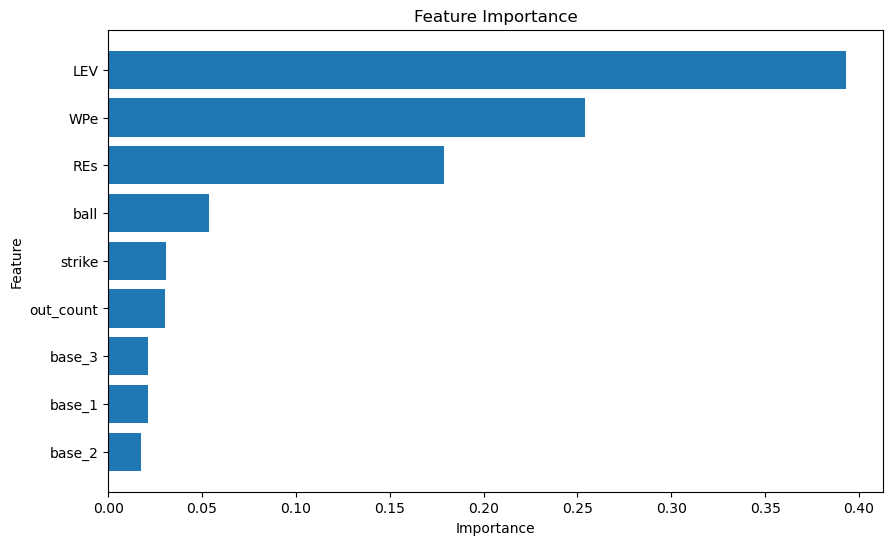

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


1번째 상황의 출루 예측 결과 : 
출루
2번째 상황의 출루 예측 결과 : 
출루


/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.79529543 0.79324939 0.79478523]
  warnings.warn(


baseball_Gradient Boosting.pkl
=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       416
           1       0.79      0.72      0.75       236

    accuracy                           0.83       652
   macro avg       0.82      0.81      0.81       652
weighted avg       0.83      0.83      0.83       652

ROC AUC: 0.8694




/var/folders/7g/d7k_fhd53k5118b5rr2p83c00000gn/T/ipykernel_36050/2178713767.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


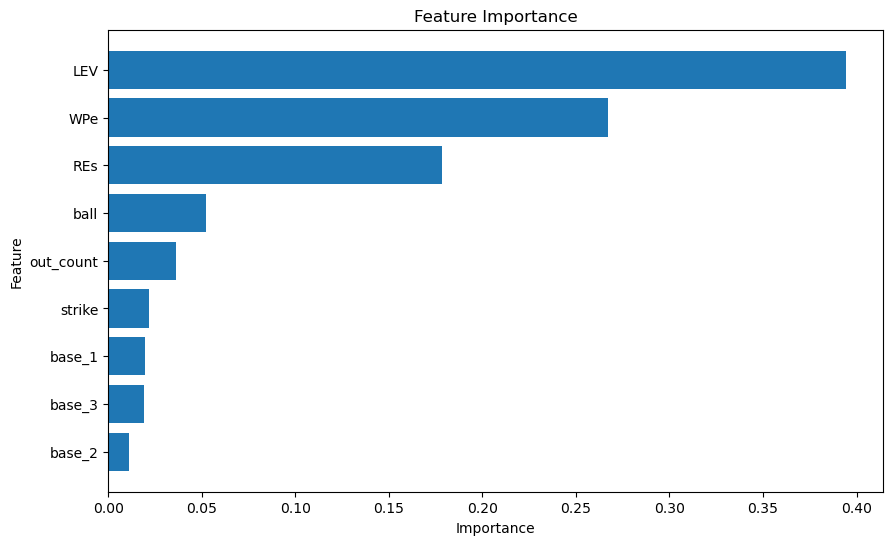

1번째 상황의 출루 예측 결과 : 
출루
2번째 상황의 출루 예측 결과 : 
출루


/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


baseball_XGBoost.pkl
=== XGBoost ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       416
           1       0.80      0.70      0.75       236

    accuracy                           0.83       652
   macro avg       0.82      0.80      0.81       652
weighted avg       0.83      0.83      0.83       652

ROC AUC: 0.8835




/var/folders/7g/d7k_fhd53k5118b5rr2p83c00000gn/T/ipykernel_36050/2178713767.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


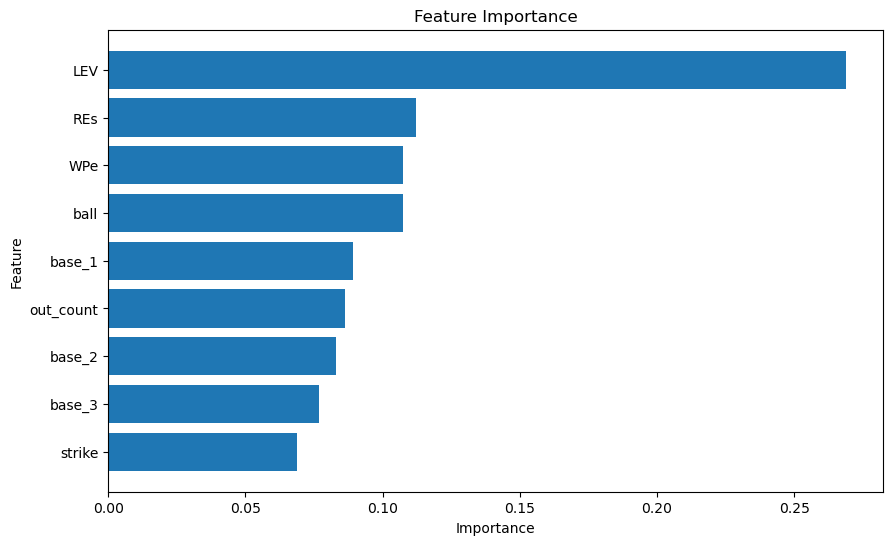

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


1번째 상황의 출루 예측 결과 : 
출루
2번째 상황의 출루 예측 결과 : 
출루
baseball_LightGBM.pkl
=== LightGBM ===
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       416
           1       0.77      0.73      0.75       236

    accuracy                           0.82       652
   macro avg       0.81      0.80      0.81       652
weighted avg       0.82      0.82      0.82       652

ROC AUC: 0.8868




/var/folders/7g/d7k_fhd53k5118b5rr2p83c00000gn/T/ipykernel_36050/2178713767.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


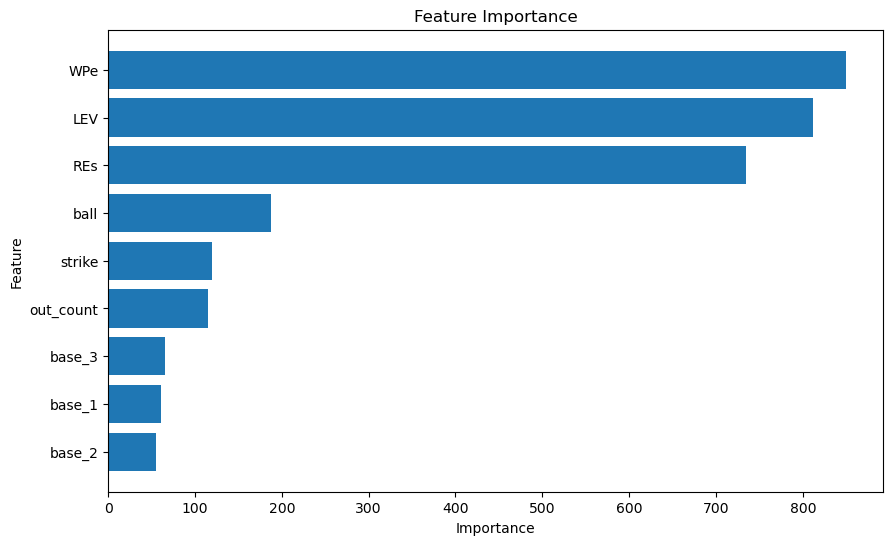

1번째 상황의 출루 예측 결과 : 
출루
2번째 상황의 출루 예측 결과 : 
출루


/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/je

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

baseball_AdaBoost.pkl
=== AdaBoost ===
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       416
           1       0.72      0.75      0.73       236

    accuracy                           0.81       652
   macro avg       0.79      0.79      0.79       652
weighted avg       0.81      0.81      0.81       652

ROC AUC: 0.8324




/var/folders/7g/d7k_fhd53k5118b5rr2p83c00000gn/T/ipykernel_36050/2178713767.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


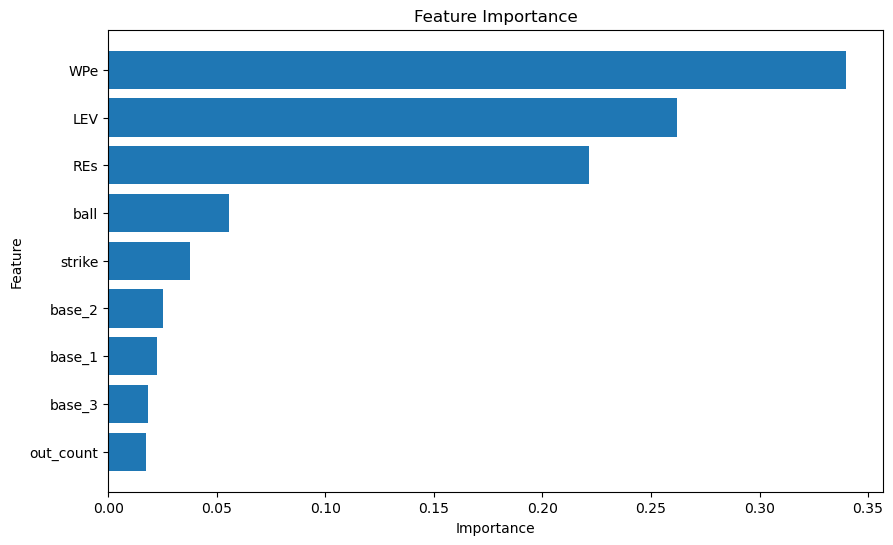

/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/jeongsoeun/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


1번째 상황의 출루 예측 결과 : 
출루
2번째 상황의 출루 예측 결과 : 
아웃


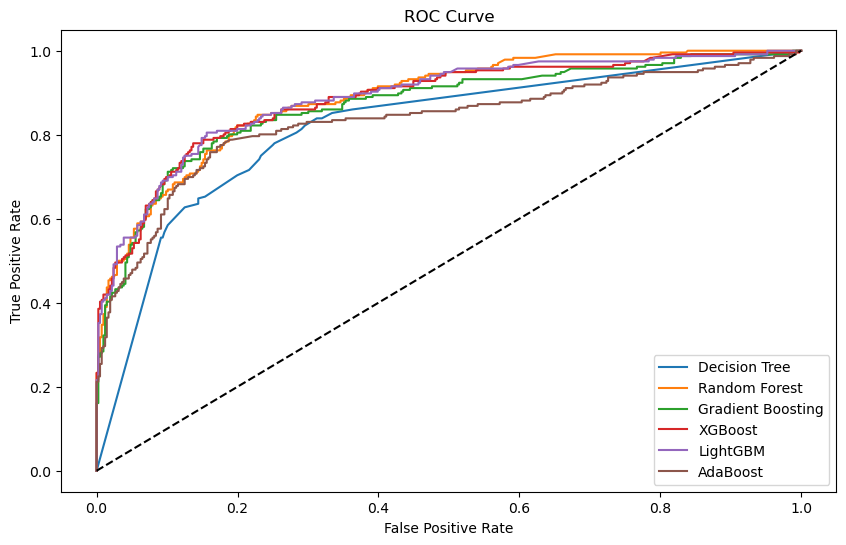

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Decision Tree,0.776074,0.706422,0.652542,0.678414,0.817603
1,Random Forest,0.808282,0.751131,0.703390,0.726477,0.887055
2,Gradient Boosting,0.829755,0.793427,0.716102,0.752784,0.869413
3,XGBoost,0.828221,0.800971,0.699153,0.746606,0.883480
4,LightGBM,0.823620,0.771300,0.728814,0.749455,0.886810
5,AdaBoost,0.805215,0.724280,0.745763,0.734864,0.832434


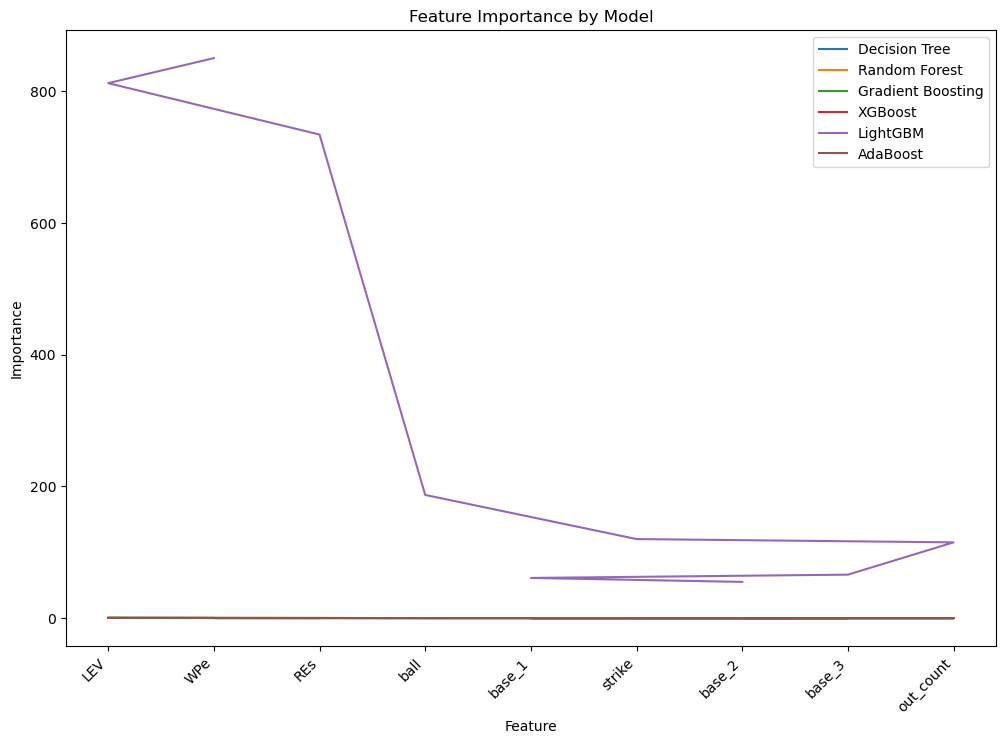

In [43]:
# 피처 중요도 색상 설정
colors = plt.cm.tab10.colors

# 모델별 성능 메트릭 수집을 위한 데이터 프레임
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# 모델별 중요도 데이터 프레임
feature_importances_dfs = {}

for i, (name, model) in enumerate(models.items()):
    
    # 모델별 하이퍼파라미터 그리드 설정
    param_grid = param_grids.get(name, {})
    
    # 모델 학습
    best_model = fit_model(model, param_grid, X_train, y_train)
    
    # 모델 파일명 출력 및 저장
    model_filename = 'baseball_' + name + '.pkl'
    print(model_filename)
    joblib.dump(best_model, model_filename)
    
    # 최적의 모델로 예측
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # 평가
    print(f"=== {name} ===")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\n")
    
    # 평가 메트릭 데이터 프레임에 추가
    metrics_df = metrics_df.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1 Score': report['1']['f1-score'],
        'ROC AUC': roc_auc
    }, ignore_index=True)
    
    if hasattr(best_model.named_steps[model.__class__.__name__.lower()], 'feature_importances_'):
        feature_importances = best_model.named_steps[model.__class__.__name__.lower()].feature_importances_
        feature_importances_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': feature_importances
        })
    
        # 중요도 순으로 정렬
        feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
    
        # 피처 중요도 시각화
        # 피처 중요도 시각화
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.gca().invert_yaxis()
        plt.show()

    
        # 피처 중요도 데이터 프레임에 저장
        feature_importances_dfs[name] = feature_importances_df
        
        # 예측 결과값 반환
        input_numerical_features_0 = [52.4, 0.553, 1.22, 3, 2, 1] # 예측에 사용할 입력 숫자형 피처 값 삽입(result : 0)
        input_numerical_features_1 = [56.1, 0.566, 1.81, 0, 2, 0] # 예측에 사용할 입력 숫자형 피처 값 삽입(result : 1)
        
        # 입력 피처값을 스케일링
        scaled_features_0, scaled_features_1 = scale_features(input_numerical_features_0, input_numerical_features_1)
        
        # 스케일링된 피처와 추가 피처 결합
        categorial_features_0 = np.array([1, 0, 0]).reshape(1, -1) # 예측에 사용할 입력 카테고리형 피처 값 삽입(result : 0)
        categorial_features_1 = np.array([0, 0, 0]).reshape(1, -1) # 예측에 사용할 입력 카테고리형 피처 값 삽입(result : 1)
        input_features_0 = np.hstack((scaled_features_0, categorial_features_0))
        input_features_1 = np.hstack((scaled_features_1, categorial_features_1))
        input_features = [input_features_0, input_features_1]                            
        search_in_model(model_filename, input_features)


# ROC-AUC 그래프
plt.figure(figsize=(10, 6))
for i, (name, model) in enumerate(models.items()):
    y_pred_proba = joblib.load('baseball_' + name + '.pkl').predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=name, color=colors[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 성능 평가 결과 표
metrics_df_styled = metrics_df.style.background_gradient(cmap='coolwarm', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
metrics_df_styled.set_caption('Performance Metrics by Model').set_table_styles([{
    'selector': 'caption',
    'props': [('color', 'black'), ('font-size', '16px')]
}])
display(metrics_df_styled)


# 피처 중요도 그래프
plt.figure(figsize=(12, 8))
for i, (name, df) in enumerate(feature_importances_dfs.items()):
    plt.plot(df['Feature'], df['Importance'], label=name, color=colors[i])

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance by Model')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()